In [219]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import matplotlib
matplotlib.use('module://ipykernel.pylab.backend_inline')
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]

In [256]:
path = "/Users/matthewmacrides/Python and R/Github/Employee Attrition - Machine Learning/"
hr = pd.read_csv(path + 'HR.csv', sep=',', decimal='.')
hr = hr.drop(columns=['EmployeeCount', 'EmployeeNumber', 'StandardHours'])
# use the map function to convert 'yes' to 1 and 'no' to 0
hr['Attrition'] = hr['Attrition'].map({'Yes': 1, 'No': 0})

In [257]:
hr.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [258]:
hr.corr().style.background_gradient(cmap="Blues")

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Age,1.000000,-0.159205,0.010661,-0.001686,0.208034,0.010146,0.024287,0.029820,0.509604,-0.004892,0.497855,0.028051,0.299635,0.003634,0.001904,0.053535,0.037510,0.680381,-0.019621,-0.021490,0.311309,0.212901,0.216513,0.202089
Attrition,-0.159205,1.000000,-0.056652,0.077924,-0.031373,-0.103369,-0.006846,-0.130016,-0.169105,-0.103481,-0.159840,0.015170,0.043494,-0.013478,0.002889,-0.045872,-0.137145,-0.171063,-0.059478,-0.063939,-0.134392,-0.160545,-0.033019,-0.156199
DailyRate,0.010661,-0.056652,1.000000,-0.004985,-0.016806,0.018355,0.023381,0.046135,0.002966,0.030571,0.007707,-0.032182,0.038153,0.022704,0.000473,0.007846,0.042143,0.014515,0.002453,-0.037848,-0.034055,0.009932,-0.033229,-0.026363
DistanceFromHome,-0.001686,0.077924,-0.004985,1.000000,0.021042,-0.016075,0.031131,0.008783,0.005303,-0.003669,-0.017014,0.027473,-0.029251,0.040235,0.027110,0.006557,0.044872,0.004628,-0.036942,-0.026556,0.009508,0.018845,0.010029,0.014406
Education,0.208034,-0.031373,-0.016806,0.021042,1.000000,-0.027128,0.016775,0.042438,0.101589,-0.011296,0.094961,-0.026084,0.126317,-0.011111,-0.024539,-0.009118,0.018422,0.148280,-0.025100,0.009819,0.069114,0.060236,0.054254,0.069065
EnvironmentSatisfaction,0.010146,-0.103369,0.018355,-0.016075,-0.027128,1.000000,-0.049857,-0.008278,0.001212,-0.006784,-0.006259,0.037600,0.012594,-0.031701,-0.029548,0.007665,0.003432,-0.002693,-0.019359,0.027627,0.001458,0.018007,0.016194,-0.004999
HourlyRate,0.024287,-0.006846,0.023381,0.031131,0.016775,-0.049857,1.000000,0.042861,-0.027853,-0.071335,-0.015794,-0.015297,0.022157,-0.009062,-0.002172,0.001330,0.050263,-0.002334,-0.008548,-0.004607,-0.019582,-0.024106,-0.026716,-0.020123
JobInvolvement,0.029820,-0.130016,0.046135,0.008783,0.042438,-0.008278,0.042861,1.000000,-0.012630,-0.021476,-0.015271,-0.016322,0.015012,-0.017205,-0.029071,0.034297,0.021523,-0.005533,-0.015338,-0.014617,-0.021355,0.008717,-0.024184,0.025976
JobLevel,0.509604,-0.169105,0.002966,0.005303,0.101589,0.001212,-0.027853,-0.012630,1.000000,-0.001944,0.950300,0.039563,0.142501,-0.034730,-0.021222,0.021642,0.013984,0.782208,-0.018191,0.037818,0.534739,0.389447,0.353885,0.375281
JobSatisfaction,-0.004892,-0.103481,0.030571,-0.003669,-0.011296,-0.006784,-0.071335,-0.021476,-0.001944,1.000000,-0.007157,0.000644,-0.055699,0.020002,0.002297,-0.012454,0.010690,-0.020185,-0.005779,-0.019459,-0.003803,-0.002305,-0.018214,-0.027656


I want to see if it's possible to predict attrition and performance so let's check the correlations of the both of them.

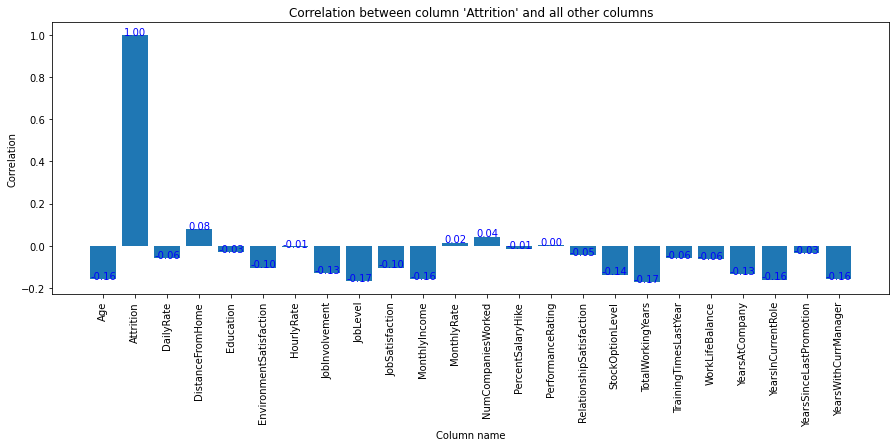

In [259]:
corr = hr.corrwith(hr['Attrition'])
plt.bar(corr.index, corr.values)
plt.title("Correlation between column 'Attrition' and all other columns")
plt.xlabel('Column name')
plt.ylabel('Correlation')
plt.xticks(rotation=90)
# Add data labels to the bar chart
for i, v in enumerate(corr.values):
    plt.text(i, v, "{:.2f}".format(v), color='blue', ha='center')
plt.show()

Nothing really stands out for attrition

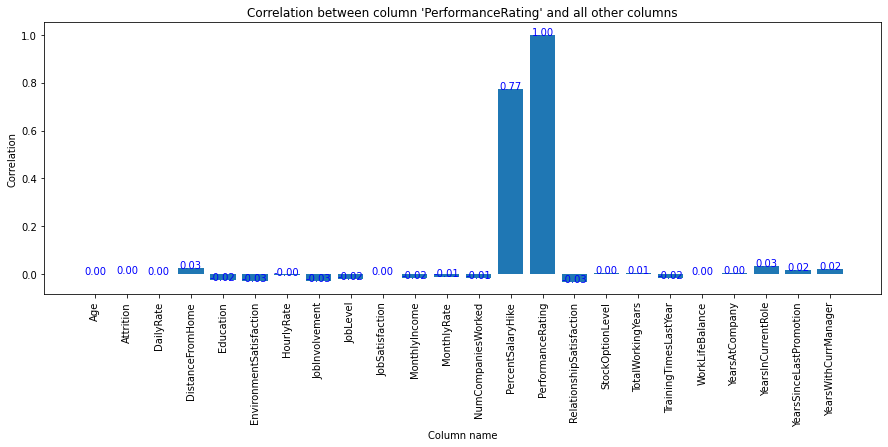

In [260]:
corr = hr.corrwith(hr['PerformanceRating'])
plt.bar(corr.index, corr.values)
plt.title("Correlation between column 'PerformanceRating' and all other columns")
plt.xlabel('Column name')
plt.ylabel('Correlation')
plt.xticks(rotation=90)
# Add data labels to the bar chart
for i, v in enumerate(corr.values):
    plt.text(i, v, "{:.2f}".format(v), color='blue', ha='center')
plt.show()

Okay, I do see percentsalaryhike is positively correlated with performance. However, it probably is not indicative of good performance because it likely happens after the fact. Regardless, let's look at a scatterplot.

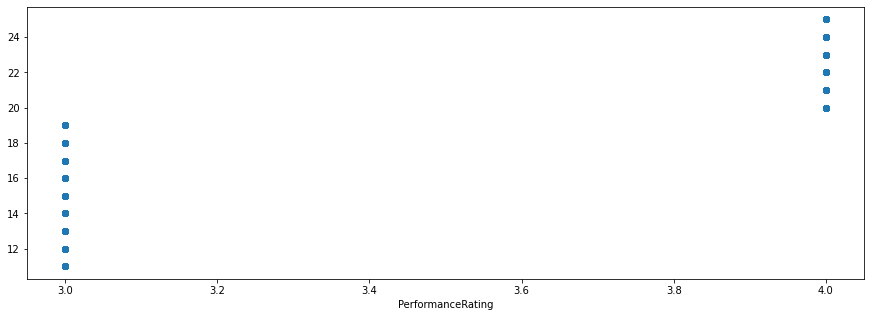

In [261]:
plt.scatter(hr['PerformanceRating'], hr['PercentSalaryHike'])
plt.xlabel('PerformanceRating')
plt.show()

Hmm this is interesting. PerformanceRating, only has two values 3 and 4. 3 indicates 'good' and 4 indicates 'excellent'. Let's see a distribution of this data column.

In [262]:
proportions = hr['PerformanceRating'].value_counts(normalize=True)
print('PerformanceRating')
print(proportions)

PerformanceRating
3    0.846259
4    0.153741
Name: PerformanceRating, dtype: float64


We can see that the majority of the employees get a 3 while only a few get 4. Let's rename the values so 1 indicates excellent and 0 indicates otherwise. I now want to create a model to predict excellent performance.

In [263]:
hr['PerformanceRating'] = hr['PerformanceRating'].map({4:1, 3:0})

Almost the same distribution as PerformanceRating but that's just a coinsidence.

In [76]:
proportions = hr['Attrition'].value_counts(normalize=True)
print('Attrition')
print(proportions)

Attrition
0    0.838776
1    0.161224
Name: Attrition, dtype: float64


Let's start prepping our other variables for modeling. Here I will turn potentially useful string variables inito dummy variables.

In [264]:
hr['BusinessTravel'] = hr['BusinessTravel'].map({'Travel_Frequently':2, 'Travel_Rarely':1, 'Non-Travel':0})
hr['Gender'] = hr['Gender'].map({'Male':1, 'Female':0})
hr['MaritalStatus'] = hr['MaritalStatus'].map({'Married':3, 'Divorced':2, 'Single':0})
hr['Over18'] = hr['Over18'].map({'Y':1})
hr['OverTime'] = hr['OverTime'].map({'Yes':1, 'No':0})

I'm now going to drop some columns that won't be helpful. I also decided to drop percentsalaryhike because it happens after the fact of a good performance. Including it would make the model 100% accurate. Let's predict performance rating first.

In [272]:
hr_performance = hr.drop(columns=['Department', 'EducationField', 'JobRole', 'PercentSalaryHike'])
# separate the target variable from the predictors
x = hr_performance.drop('PerformanceRating', axis=1)
y = hr_performance['PerformanceRating']
target = "PerformanceRating"

In [305]:
def modeling(x, y, target):

    # split the data into training and testing sets, with stratification - to ensure that the distribution is the same for train and test
    x_train_0, x_test_0, y_train_0, y_test_0 = train_test_split(x[y==0], y[y==0], test_size=0.5, stratify=y[y==0])
    x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x[y==1], y[y==1], test_size=0.5, stratify=y[y==1])

    # concatenate the training and testing sets for both classes
    x_train = pd.concat([x_train_0, x_train_1], axis=0)
    x_test = pd.concat([x_test_0, x_test_1], axis=0)
    y_train = pd.concat([y_train_0, y_train_1], axis=0)
    y_test = pd.concat([y_test_0, y_test_1], axis=0)

    feature_list = list(x_train.columns)
    compare = pd.DataFrame()
    features = pd.DataFrame()

    model_ = RandomForestClassifier()
    model_.fit(x_train, y_train.values.ravel())
    y_pred = model_.predict(x_test)

    # predict probabilities for the test data
    y_pred_proba = model_.predict_proba(x_test)[:, 1] # assuming your target variable is binary 0 or 1
    # calculate AUC-ROC score
    auc = roc_auc_score(y_test, y_pred_proba)
    data = {'AUC': [auc]}
    auc = pd.DataFrame(data)
    if target == "PerformanceRating": compare['PerformanceRating'] = y_test
    if target == "PerformanceRating": compare['Pred PerformanceRating'] = y_pred
    if target == "Attrition": compare['Attrition'] = y_test
    if target == "Attrition": compare['Pred Attrition'] = y_pred

    # Store the variable importances
    # Get numerical feature importances
    importances = list(model_.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    features_ = pd.DataFrame(feature_importances, columns=['Variables', 'Importance'])
    features_ = features_.head(5)
    features = pd.concat([features, features_], ignore_index=True)
    return auc, features, compare

In [300]:
auc, features, compare = modeling(x, y, target)

TypeError: modeling() missing 1 required positional argument: 'target'

In [275]:
auc

,AUC
0,0.460639


In [301]:
hr_attrition = hr.drop(columns=['Department', 'EducationField', 'JobRole', 'PercentSalaryHike'])
# separate the target variable from the predictors
x = hr_attrition.drop('Attrition', axis=1)
y = hr_attrition['Attrition']
target = 'Attrition'

In [306]:
auc, features, compare = modeling(x, y, target)

In [307]:
auc

,AUC
0,0.784277


In [308]:
features

,Variables,Importance
0,Age,0.08
1,MonthlyIncome,0.08
2,DailyRate,0.07
3,TotalWorkingYears,0.07
4,MonthlyRate,0.06
